### Total dissipation (global) at 4km MOM6 vs. TPXO8 dissipation

In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

from scipy.io import loadmat

#### TPXO8 dissipation (M2)

In [2]:
# Load the .mat file
data = loadmat('/g/data/nm03/lxy581/TPXO8dissip/m2hf.m2_tpxo8_atlas_30c.out_diss.mat')

# Access a variable
dissip8 = data['diss']
hz = data['hz'] # depth
lon = data['lon'] # (lat, lon)
lat = data['lat']
ny_tpxo, nx_tpxo = lon.shape

#### Reorganize TPXO8 data to match 4km grid so you could use area_004!

In [3]:
lon_shift = np.full((lon.shape),np.nan)
lat_shift = np.full((lat.shape),np.nan)
dissip8_shift = np.full((dissip8.shape),np.nan)

lon_shift[:,9000:10800] = lon[:,0:1800]
lon_shift[:,0:9000] = lon[:,1800:] - lon[0,-1]
dissip8_shift[:,9000:10800] = dissip8[:,0:1800]
dissip8_shift[:,0:9000] = dissip8[:,1800:] 

In [4]:
# plt.pcolormesh(lon_shift, lat, dissip8_shift*1e+3, cmap=cm.cm.thermal, norm=LogNorm(vmin=1e-2, vmax=1e+2))

#### Topography

In [4]:
grid_4km = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_004_global_sigma_x06/output002/ocean_static.nc')
lon_4km = np.array(grid_4km['geolon'])
lat_4km = np.array(grid_4km['geolat'])
area_004 = np.array(grid_4km['areacello'])
depth_4km =np.array(grid_4km['deptho'])
depth_4km[depth_4km==0]=np.nan
yh, xh = grid_4km.yh, grid_4km.xh
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_4km),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_4km),
                              'lat': (('yh', 'xh'), lat_4km)})
land_4km = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

#### Regrid TPXO8 dissipation to MOM6 4km grid

In [5]:
ds_tpxo = xr.Dataset(data_vars={"dissip": (("ny","nx"), np.array(dissip8_shift)),
                                "lat": (("ny","nx"), lat),
                                "lon": (("ny","nx"), lon_shift),
                               },
                     coords={"ny":np.arange(ny_tpxo), "nx":np.arange(nx_tpxo)})
ds_tpxo.to_netcdf('/g/data/nm03/lxy581/TPXO8dissip/m2_tpxo8_atlas_30c.nc')
ds_4km = xr.Dataset(data_vars={"lat": (("ny","nx"), lat_4km),
                               "lon": (("ny","nx"), lon_4km),
                              },
                    coords={"ny":np.arange(grid_4km.yh.size), "nx":np.arange(grid_4km.xh.size)})

In [6]:
regridder_tpxo = xe.Regridder(ds_tpxo, ds_4km, "bilinear", extrap_method="inverse_dist", reuse_weights=True, weights= 
                              "/g/data/nm03/lxy581/TPXO8dissip/tpxo8_to_4km_weights.nc")
ds_tpxo_lres = regridder_tpxo(ds_tpxo)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [7]:
dissip8_lres = ds_tpxo_lres.dissip * 1e+3

In [8]:
fac_neg = xr.where(dissip8_lres>0, 1, 0)
dissip8_corr = dissip8_lres * fac_neg
print(np.nanmin(dissip8_corr))

0.0


#### 4 km linear

In [9]:
dir_cdrag_lin = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_cdrag_interp_x10.nc'
data_cdrag_lin = xr.open_dataset(dir_cdrag_lin)
cdrag_lin = data_cdrag_lin.dissip_cdrag * 1e+3

In [10]:
dir_sigma_lin = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_sigma_interp_x10.nc'
data_sigma_lin = xr.open_dataset(dir_sigma_lin)
sigma_lin = data_sigma_lin.dissip_cdrag * 1e+3

In [11]:
dissip_lin = cdrag_lin + sigma_lin
global_dissip_lin = 2.98395875

#### 4 km linear corrected

In [12]:
dir_cdrag_iFr = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_cdrag_iFr_interp_x17.nc'
data_cdrag_iFr = xr.open_dataset(dir_cdrag_iFr)
cdrag_iFr = data_cdrag_iFr.dissip_cdrag * 1e+3

dir_sigma_iFr = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_sigma_iFr_interp_x17.nc'
data_sigma_iFr = xr.open_dataset(dir_sigma_iFr)
sigma_iFr = data_sigma_iFr.dissip_sigma * 1e+3

dissip_iFr = cdrag_iFr + sigma_iFr
global_dissip_iFr = 2.90305444

#### 4 km nonlinear

In [13]:
dir_cdrag_non = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_cdrag_interp_x15_nonlinear.nc'
data_cdrag_non = xr.open_dataset(dir_cdrag_non)
cdrag_non = data_cdrag_non.dissip_cdrag * 1e+3

In [14]:
dir_sigma_non = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_sigma_interp_x15_nonlinear.nc'
data_sigma_non = xr.open_dataset(dir_sigma_non)
sigma_non = data_sigma_non.dissip_sigma * 1e+3

In [15]:
dissip_non = cdrag_non + sigma_non
global_dissip_non = 2.85686026

#### 4 km nonlinear corrected

In [16]:
dir_cdrag_iFrn = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_cdrag_iFrn_interp_x22.nc'
data_cdrag_iFrn = xr.open_dataset(dir_cdrag_iFrn)
cdrag_iFrn = data_cdrag_iFrn.dissip_cdrag * 1e+3

dir_sigma_iFrn = '/g/data/nm03/lxy581/evaluate/dissip/M2_dissip_004_sigma_iFrn_interp_x22.nc'
data_sigma_iFrn = xr.open_dataset(dir_sigma_iFrn)
sigma_iFrn = data_sigma_iFrn.dissip_sigma * 1e+3

dissip_iFrn = cdrag_iFrn + sigma_iFrn
global_dissip_iFrn = 2.81941791

In [17]:
sigma_dissip_lin = 1.45
sigma_dissip_iFr = 1.32
sigma_dissip_non = 1.33
sigma_dissip_iFrn = 1.25

In [18]:
fkbar = xr.open_dataset('/g/data/nm03/lxy581/evaluate/tuning/ukbar_SAH_M2_4km.nc')
omega = 2 * np.pi / (12.4206014*3600)
uk_omega = fkbar['uk']*2*np.pi/omega

In [19]:
iFr_data = xr.open_dataset('/g/data/nm03/lxy581/evaluate/tuning/iFr_4km_SAH_M2_Nbot.nc')
iFr = iFr_data.iFr

In [20]:
mask = (iFr < 0.4) & (uk_omega > 0.1)
mask_iFr = iFr < 0.4
mask_exc = uk_omega > 0.1

In [22]:
# Mid-Atlantic Ridge
lon_min_atl, lon_max_atl = -50, -30  # min/max longitude
lat_min_atl, lat_max_atl = -20, 30   # min/max latitude

# Indonesian Archipelago
lon_min_isl, lon_max_isl = -265, -229  # min/max longitude
lat_min_isl, lat_max_isl = -30, 0   # min/max latitude

# Mid-Indian Ridge
lon_min_ind, lon_max_ind = -300, -250  # min/max longitude
lat_min_ind, lat_max_ind = -60, 10   # min/max latitude

In [23]:
print(np.nanmax(depth_4km))
fac_dep = xr.where(depth_4km>1000,1,0)
global_dissip8 = np.nansum(dissip8_lres * area_004) / 1e+15
deep_dissip8 = np.nansum(dissip8_lres * fac_dep * area_004) / 1e+15
perc_dissip8 = deep_dissip8 / global_dissip8
print(global_dissip8, perc_dissip8)

fac_atl = xr.where((lat_4km>lat_min_atl)&(lat_4km<lat_max_atl)&(lon_4km>lon_min_atl)&(lon_4km<lon_max_atl), 1, np.nan) 
fac_isl = xr.where((lat_4km>lat_min_isl)&(lat_4km<lat_max_isl)&(lon_4km>lon_min_isl)&(lon_4km<lon_max_isl), 1, np.nan) 
fac_ind = xr.where((lat_4km>lat_min_ind)&(lat_4km<lat_max_ind)&(lon_4km>lon_min_ind)&(lon_4km<lon_max_ind), 1, np.nan) 

dissip8_lres_atl = np.nansum(dissip8_lres * fac_atl * area_004) / 1e+15
dissip_lin_atl = np.nansum(dissip_lin * fac_atl * area_004) / 1e+15
dissip_iFr_atl = np.nansum(dissip_iFr * fac_atl * area_004) / 1e+15
dissip_non_atl = np.nansum(dissip_non * fac_atl * area_004) / 1e+15
dissip_iFrn_atl = np.nansum(dissip_iFrn * fac_atl * area_004) / 1e+15
print(dissip8_lres_atl, dissip_lin_atl, dissip_iFr_atl, dissip_non_atl, dissip_iFrn_atl)

dissip8_lres_isl = np.nansum(dissip8_lres * fac_isl * area_004) / 1e+15
dissip_lin_isl = np.nansum(dissip_lin * fac_isl * area_004) / 1e+15
dissip_iFr_isl = np.nansum(dissip_iFr * fac_isl * area_004) / 1e+15
dissip_non_isl = np.nansum(dissip_non * fac_isl * area_004) / 1e+15
dissip_iFrn_isl = np.nansum(dissip_iFrn * fac_isl * area_004) / 1e+15
print(dissip8_lres_isl, dissip_lin_isl, dissip_iFr_isl, dissip_non_isl, dissip_iFrn_isl)

dissip8_lres_ind = np.nansum(dissip8_lres * fac_ind * area_004) / 1e+15
dissip_lin_ind = np.nansum(dissip_lin * fac_ind * area_004) / 1e+15
dissip_iFr_ind = np.nansum(dissip_iFr * fac_ind * area_004) / 1e+15
dissip_non_ind = np.nansum(dissip_non * fac_ind * area_004) / 1e+15
dissip_iFrn_ind = np.nansum(dissip_iFrn * fac_ind * area_004) / 1e+15
print(dissip8_lres_ind, dissip_lin_ind, dissip_iFr_ind, dissip_non_ind, dissip_iFrn_ind)

6500.0
2.4780173496319864 0.3304274366374547
0.11252527574484399 0.14100604814138823 0.11992728965628653 0.150221799115067 0.1284025872064326
0.16449419445406557 0.15332732229810753 0.09506131726635077 0.14931923431668268 0.08372074266582492
0.1252829546662413 0.16666638553766114 0.14418225806772283 0.15586448522663238 0.1325436827626753


In [24]:
fac_neg2 = np.array(xr.where(dissip8_lres>0, 1, np.nan))
dissip_diff_lin = (dissip_lin - np.array(dissip8_corr))*fac_dep*fac_neg2
dissip_diff_non = (dissip_non - np.array(dissip8_corr))*fac_dep*fac_neg2
dissip_diff_iFr = (dissip_iFr - np.array(dissip8_corr))*fac_dep*fac_neg2
dissip_diff_iFrn = (dissip_iFrn - np.array(dissip8_corr))*fac_dep*fac_neg2
# print(np.nanmin(dissip_diff_lin),np.nanmax(dissip_diff_lin))
# print(np.nanmin(dissip_diff_iFr),np.nanmax(dissip_diff_iFr))
# print(np.nanmin(dissip_diff_non),np.nanmax(dissip_diff_non))
# print(np.nanmin(dissip_diff_iFrn),np.nanmax(dissip_diff_iFrn))

In [25]:
start_time = time.time()

Start plotting...
0
Plotting linear diff...
1
Plotting iFr diff...
2
Plotting non dissip...
3
Plotting iFrn diff...
Saving...


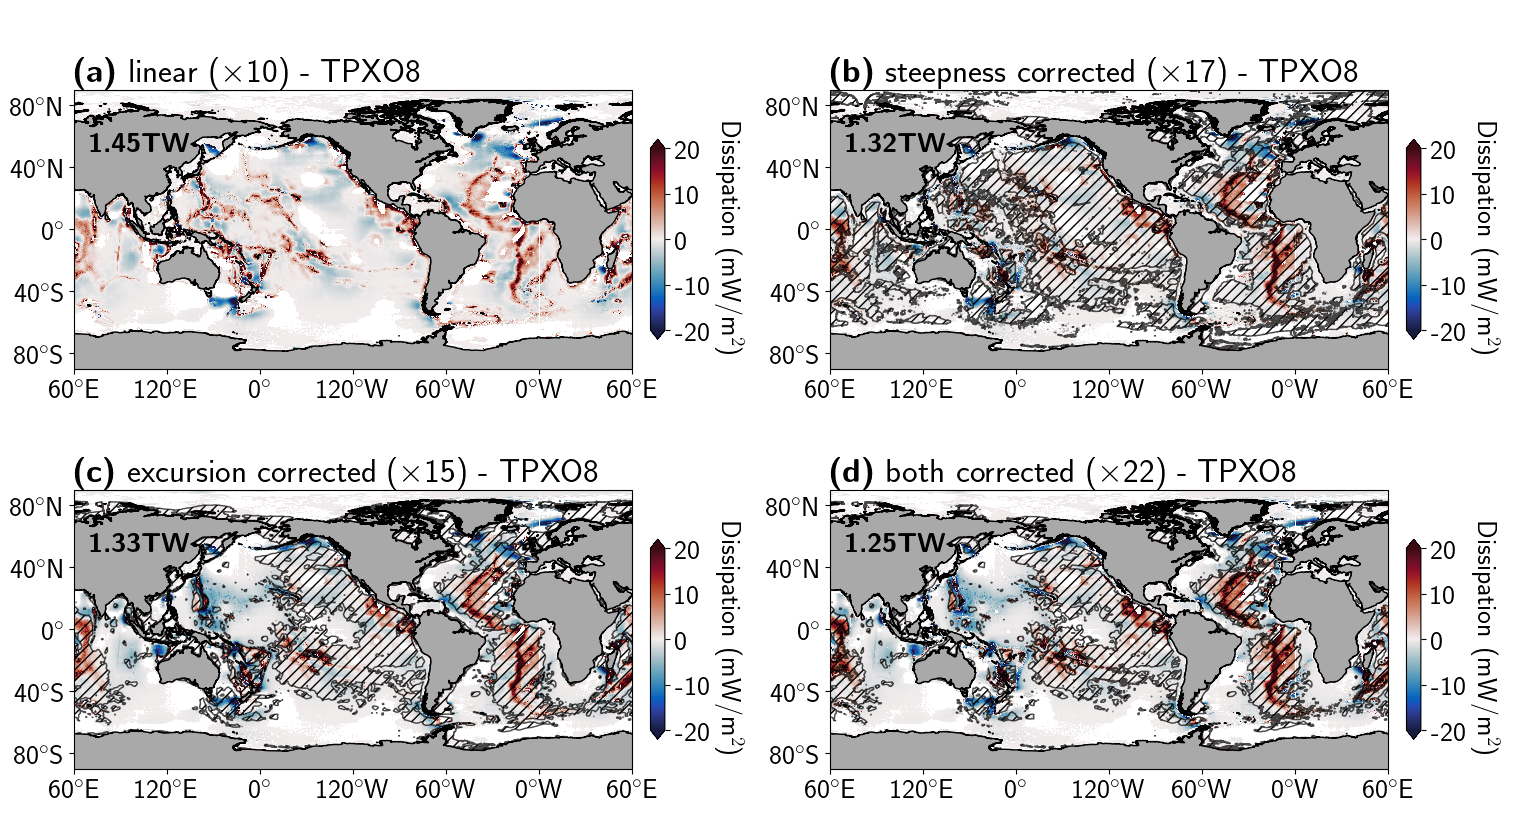

In [26]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

lon = ['lon_4km','lon_4km','lon_4km','lon_4km']
lat = ['lat_4km','lat_4km','lat_4km','lat_4km']

varlist = ['dissip_diff_lin', 'dissip_diff_iFr', 'dissip_diff_non', 'dissip_diff_iFrn']
title   = [r'\textbf{(a)} linear ($\times$10) - TPXO8', 
           r'\textbf{(b)} steepness corrected ($\times$17) - TPXO8', 
           r'\textbf{(c)} excursion corrected ($\times$15) - TPXO8', 
           r'\textbf{(d)} both corrected ($\times$22) - TPXO8']

# dissip
dissip_tick_locs = np.array([1e-2,1e-1,1e+0,1e+1,1e+2])
dissip_tick_labels = np.array(["10$^{-2}$","10$^{-1}$","10$^{0}$","10$^{1}$","10$^{2}$"])

# diff
diff_tick_locs = np.array([-20,-10,0,10,20])
diff_tick_labels = np.array(["-20","-10","0","10","20"])

vmin, vmax = -20, 20

fig = plt.figure(figsize=(18, 10))
axs = []

gridsubs = gridspec.GridSpec(2,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    if I==0:
        print('Plotting linear diff...')
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
        # Add model land mask
        land_4km.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
        # Add model coastline
        land_4km.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=1)
        p1 = ax.pcolormesh(globals()[lon[I]], globals()[lat[I]], globals()[var], cmap=cm.cm.balance, vmin=vmin, vmax=vmax) 
        # ax.contour(lon_4km, lat_4km, mask, colors='k',alpha=0.7,levels=[0.5], linewidths=1)
        # ax.contourf(lon_4km, lat_4km, mask, levels=[0.5, 1.5], hatches=['///'], alpha=0)
        ax.set_xlim(-300,60)
        ax.set_xticks(np.arange(-300,60+60,60))
        ax.set_xticklabels(['60$^{\circ}$E','120$^{\circ}$E','0$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W','0$^{\circ}$W','60$^{\circ}$E'])
        ax.set_yticks(np.arange(-80,80+40,40))
        ax.set_yticklabels(['80$^{\circ}$S','40$^{\circ}$S','0$^{\circ}$','40$^{\circ}$N','80$^{\circ}$N'])
        ax.tick_params(labelsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax_cb = plt.axes([0.42, 0.55, 0.008, 0.2])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Dissipation (mW/m$^2$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=20)
        cb1.locator   = matplotlib.ticker.FixedLocator(diff_tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(diff_tick_labels)
        ax.set_position([0.1,0.5,0.31,0.32])
        ax.set_title(title[I],fontsize=24,loc="left")
        ax.text(-290,50,r'\textbf{%.2fTW}'%sigma_dissip_lin, color='k', fontweight='bold', fontsize=20)

    if I==1:
        print('Plotting iFr diff...')
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
        # Add model land mask
        land_4km.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
        # Add model coastline
        land_4km.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=1)
        p1 = ax.pcolormesh(globals()[lon[I]], globals()[lat[I]], globals()[var], cmap=cm.cm.balance, vmin=vmin, vmax=vmax)
        ax.contour(lon_4km, lat_4km, mask_iFr, colors='k',alpha=0.7,levels=[0.5], linewidths=1)
        ax.contourf(lon_4km, lat_4km, mask_iFr, levels=[0.5, 1.5], hatches=['///'], alpha=0)
        ax.set_xlim(-300,60)
        ax.set_xticks(np.arange(-300,60+60,60))
        ax.set_xticklabels(['60$^{\circ}$E','120$^{\circ}$E','0$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W','0$^{\circ}$W','60$^{\circ}$E'])
        ax.set_yticks(np.arange(-80,80+40,40))
        ax.set_yticklabels(['80$^{\circ}$S','40$^{\circ}$S','0$^{\circ}$','40$^{\circ}$N','80$^{\circ}$N'])
        ax.tick_params(labelsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax_cb = plt.axes([0.84, 0.55, 0.008, 0.2])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Dissipation (mW/m$^2$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=20)
        cb1.locator   = matplotlib.ticker.FixedLocator(diff_tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(diff_tick_labels)
        ax.set_position([0.52,0.5,0.31,0.32])
        ax.set_title(title[I],fontsize=24,loc="left")
        ax.text(-290,50,r'\textbf{%.2fTW}'%sigma_dissip_iFr, color='k', fontweight='bold', fontsize=20)

    if I==2:
        print('Plotting non dissip...')
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
        # Add model land mask
        land_4km.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
        # Add model coastline
        land_4km.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=1)
        p1 = ax.pcolormesh(globals()[lon[I]], globals()[lat[I]], globals()[var], cmap=cm.cm.balance, vmin=vmin, vmax=vmax) #norm=LogNorm(vmin=1e-2, vmax=1e-0)
        ax.contour(lon_4km, lat_4km, mask_exc, colors='k',alpha=0.7,levels=[0.5], linewidths=1)
        ax.contourf(lon_4km, lat_4km, mask_exc, levels=[0.5, 1.5], hatches=['///'], alpha=0)
        ax.set_xlim(-300,60)
        ax.set_xticks(np.arange(-300,60+60,60))
        ax.set_xticklabels(['60$^{\circ}$E','120$^{\circ}$E','0$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W','0$^{\circ}$W','60$^{\circ}$E'])
        ax.set_yticks(np.arange(-80,80+40,40))
        ax.set_yticklabels(['80$^{\circ}$S','40$^{\circ}$S','0$^{\circ}$','40$^{\circ}$N','80$^{\circ}$N'])
        ax.tick_params(labelsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax_cb = plt.axes([0.42, 0.15, 0.008, 0.2])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Dissipation (mW/m$^2$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=20)
        cb1.locator   = matplotlib.ticker.FixedLocator(diff_tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(diff_tick_labels)
        ax.set_position([0.1,0.1,0.31,0.32])
        ax.set_title(title[I],fontsize=24,loc="left")
        ax.text(-290,50,r'\textbf{%.2fTW}'%sigma_dissip_non, color='k', fontweight='bold', fontsize=20)


    # # Define the corners of the box in order (closing the polygon)
    # box_lons_atlantic = [lon_min_atl, lon_max_atl, lon_max_atl, lon_min_atl, lon_min_atl]
    # box_lats_atlantic = [lat_min_atl, lat_min_atl, lat_max_atl, lat_max_atl, lat_min_atl]


    # # Define the corners of the box in order (closing the polygon)
    # box_lons_island = [lon_min_isl, lon_max_isl, lon_max_isl, lon_min_isl, lon_min_isl]
    # box_lats_island = [lat_min_isl, lat_min_isl, lat_max_isl, lat_max_isl, lat_min_isl]

   
    # # Define the corners of the box in order (closing the polygon)
    # box_lons_indian = [lon_min_ind, lon_max_ind, lon_max_ind, lon_min_ind, lon_min_ind]
    # box_lats_indian = [lat_min_ind, lat_min_ind, lat_max_ind, lat_max_ind, lat_min_ind]
    
    if I==3:
        print('Plotting iFrn diff...')
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
        # Add model land mask
        land_4km.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
        # Add model coastline
        land_4km.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=1)
        p1 = ax.pcolormesh(globals()[lon[I]], globals()[lat[I]], globals()[var], cmap=cm.cm.balance, vmin=vmin, vmax=vmax)
        # ax.plot(box_lons_atlantic, box_lats_atlantic, color=(0.0, 0.5, 0.0), linewidth=2)
        # ax.plot(box_lons_island, box_lats_island, color=(0.0, 0.5, 0.0), linewidth=2)
        # ax.plot(box_lons_indian, box_lats_indian, color=(0.0, 0.5, 0.0), linewidth=2)
        ax.contour(lon_4km, lat_4km, mask, colors='k',alpha=0.7,levels=[0.5], linewidths=1)
        ax.contourf(lon_4km, lat_4km, mask, levels=[0.5, 1.5], hatches=['///'], alpha=0)
        ax.set_xlim(-300,60)
        ax.set_xticks(np.arange(-300,60+60,60))
        ax.set_xticklabels(['60$^{\circ}$E','120$^{\circ}$E','0$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W','0$^{\circ}$W','60$^{\circ}$E'])
        ax.set_yticks(np.arange(-80,80+40,40))
        ax.set_yticklabels(['80$^{\circ}$S','40$^{\circ}$S','0$^{\circ}$','40$^{\circ}$N','80$^{\circ}$N'])
        ax.tick_params(labelsize=20)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax_cb = plt.axes([0.84, 0.15, 0.008, 0.2])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel('Dissipation (mW/m$^2$)',fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=20)
        cb1.locator   = matplotlib.ticker.FixedLocator(diff_tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(diff_tick_labels)
        ax.set_position([0.52,0.1,0.31,0.32])
        ax.set_title(title[I],fontsize=24,loc="left")
        ax.text(-290,50,r'\textbf{%.2fTW}'%sigma_dissip_iFrn, color='k', fontweight='bold', fontsize=20)

print('Saving...')
plt.savefig('/g/data/nm03/lxy581/evaluate/dissip/MOM6_SAH_M2_sigma_004_TPXO_global.png', dpi=300, bbox_inches='tight')
# plt.savefig('/g/data/nm03/lxy581/evaluate/dissip/MOM6_SAH_M2_dissip_004_TPXO_global.png', dpi=300, bbox_inches='tight')

In [27]:
end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f mins!" % (exe_time/60.0))

Execution time: 7.3 mins!


In [29]:
# dissip_diff_lin = (dissip_lin - np.array(dissip8_corr))*fac_dep
# dissip_diff_non = (dissip_non - np.array(dissip8_corr))*fac_dep
# dissip_diff_iFr = (dissip_iFr - np.array(dissip8_corr))*fac_dep
# dissip_diff_iFrn = (dissip_iFrn - np.array(dissip8_corr))*fac_dep
# mask = (iFr < 0.4) & (uk_omega > 0.1)
# mask_iFr = iFr < 0.4
# mask_exc = uk_omega > 0.1

fac_sup = np.array(xr.where(iFr > 0.4,1,np.nan))
fac_iFr = np.array(xr.where(iFr < 0.4,1,np.nan))
fac_exc = np.array(xr.where(uk_omega > 0.1,1,np.nan))
fac_iFrn = np.array(xr.where((iFr < 0.4)&(uk_omega > 0.1),1,np.nan))
fac_lin = np.array(xr.where((iFr < 0.4)&(uk_omega < 0.1),1,np.nan))

fac_dep = xr.where(depth_4km>1000,1,0)
global_dissip8 = np.nansum(dissip8_lres * area_004) / 1e+15
deep_dissip8 = np.nansum(dissip8_lres * fac_dep * area_004) / 1e+15
perc_dissip8 = deep_dissip8 / global_dissip8
print(global_dissip8, perc_dissip8)

iFr_dissip8 = np.nansum(dissip8_lres * fac_dep * fac_iFr * area_004) / 1e+15
frac_iFr = 1 - iFr_dissip8 / deep_dissip8
print('%.2f'%frac_iFr)

exc_dissip8 = np.nansum(dissip8_lres * fac_dep * fac_exc * area_004) / 1e+15
frac_exc = iFr_dissip8 / deep_dissip8
print('%.2f'%frac_exc)

iFrn_dissip8 = np.nansum(dissip8_lres * fac_dep * fac_iFrn * area_004) / 1e+15
frac_iFrn = iFrn_dissip8 / deep_dissip8
print('%.2f'%frac_iFrn)

lin_dissip8 = np.nansum(dissip8_lres * fac_dep * fac_lin * area_004) / 1e+15
frac_lin = lin_dissip8 / deep_dissip8
print('%.2f'%frac_lin)

# fac_neg2 = np.array(xr.where(dissip8_lres>0, 1, np.nan))
# dissip_diff_lin = (dissip_lin - np.array(dissip8_corr))*fac_dep*fac_neg2
# dissip_diff_non = (dissip_non - np.array(dissip8_corr))*fac_dep*fac_neg2
# dissip_diff_iFr = (dissip_iFr - np.array(dissip8_corr))*fac_dep*fac_neg2
# dissip_diff_iFrn = (dissip_iFrn - np.array(dissip8_corr))*fac_dep*fac_neg2

# # iFr
# diff_lin_int = np.nansum(dissip_diff_lin * fac_sup * area_004)/1e+15
# diff_iFr_int = np.nansum(dissip_diff_iFr * fac_sup * area_004)/1e+15
# print('%.2fTW'%diff_lin_int, '%.2fTW'%diff_iFr_int)

# # non
# diff_lin_int = np.nansum(dissip_diff_lin * fac_exc * area_004)/1e+15
# diff_non_int = np.nansum(dissip_diff_non * fac_exc * area_004)/1e+15
# print('%.2fTW'%diff_lin_int, '%.2fTW'%diff_non_int)

# # iFrn
# diff_lin_int = np.nansum(dissip_diff_lin * fac_iFrn * area_004)/1e+15
# diff_iFrn_int = np.nansum(dissip_diff_iFrn * fac_iFrn * area_004)/1e+15
# print('%.2fTW'%diff_lin_int, '%.2fTW'%diff_iFrn_int)

2.4780173496319864 0.3304274366374547
0.47
0.53
0.41
0.12


In [29]:
# fac_atl = xr.where((lat_4km>lat_min_atl)&(lat_4km<lat_max_atl)&(lon_4km>lon_min_atl)&(lon_4km<lon_max_atl), 1, np.nan) 
# fac_isl = xr.where((lat_4km>lat_min_isl)&(lat_4km<lat_max_isl)&(lon_4km>lon_min_isl)&(lon_4km<lon_max_isl), 1, np.nan) 
# fac_ind = xr.where((lat_4km>lat_min_ind)&(lat_4km<lat_max_ind)&(lon_4km>lon_min_ind)&(lon_4km<lon_max_ind), 1, np.nan) 

# dissip_diff_non = dissip_non - dissip_lin
# dissip_diff_iFr = dissip_iFr - dissip_lin
# dissip_diff_iFrn = dissip_iFrn - dissip_lin

# sigma_iFrn_atl = np.nansum(sigma_iFrn * fac_atl * area_004)
# sigma_lin_atl = np.nansum(sigma_lin * fac_atl * area_004)
# frac_iFrn_atl = (sigma_iFrn_atl - sigma_lin_atl) / sigma_lin_atl
# print(frac_iFrn_atl)

# sigma_iFrn_isl = np.nansum(sigma_iFrn * fac_isl * area_004)
# sigma_lin_isl = np.nansum(sigma_lin * fac_isl * area_004)
# frac_iFrn_isl = (sigma_iFrn_isl - sigma_lin_isl) / sigma_lin_isl
# print(frac_iFrn_isl)

# sigma_iFrn_ind = np.nansum(sigma_iFrn * fac_ind * area_004)
# sigma_lin_ind = np.nansum(sigma_lin * fac_ind * area_004)
# frac_iFrn_ind = (sigma_iFrn_ind - sigma_lin_ind) / sigma_lin_ind
# print(frac_iFrn_ind)